## Compare linear and exponential model for kinetics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import calibr8
from matplotlib import pyplot
import numpy
import os
import pathlib
import pymc
import scipy
import string

import cutisplit
import run_analysis


print(f"pymc {pymc.__version__}")
print(f"calibr8 {calibr8.__version__}")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc 4.0.0b2
calibr8 6.5.2


## Read the data 

Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited


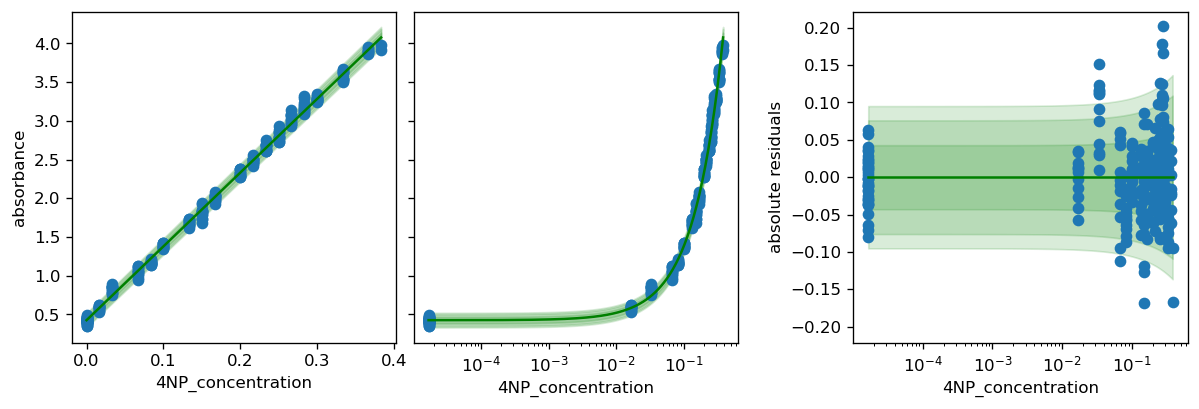

In [3]:
RUN_ID = "BZACW9"
resultpath = f'{RUN_ID}_Results' 
parent_dir = pathlib.Path(os.getcwd()).parent
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(
    rf"{parent_dir}\data_analysis\{resultpath}\{RUN_ID}_cm_nitrophenol.json"
)
calibr8.plot_model(cm_nitrophenol)

df_inputs, df_kinetics = run_analysis.read_rounds(["BWA7DQ", "BZACW9"])

## Load the linear and non-linear data

In [4]:
idata_linear = arviz.from_netcdf(
    rf"{parent_dir}\data_analysis\{resultpath}\{RUN_ID}_result_linear-comparison.nc"
)
idata_nonlinear = arviz.from_netcdf(
    rf"{parent_dir}\data_analysis\{resultpath}\{RUN_ID}_LCC_round1.nc"
)

## Comparitive plot for one strain

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.5_v2\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


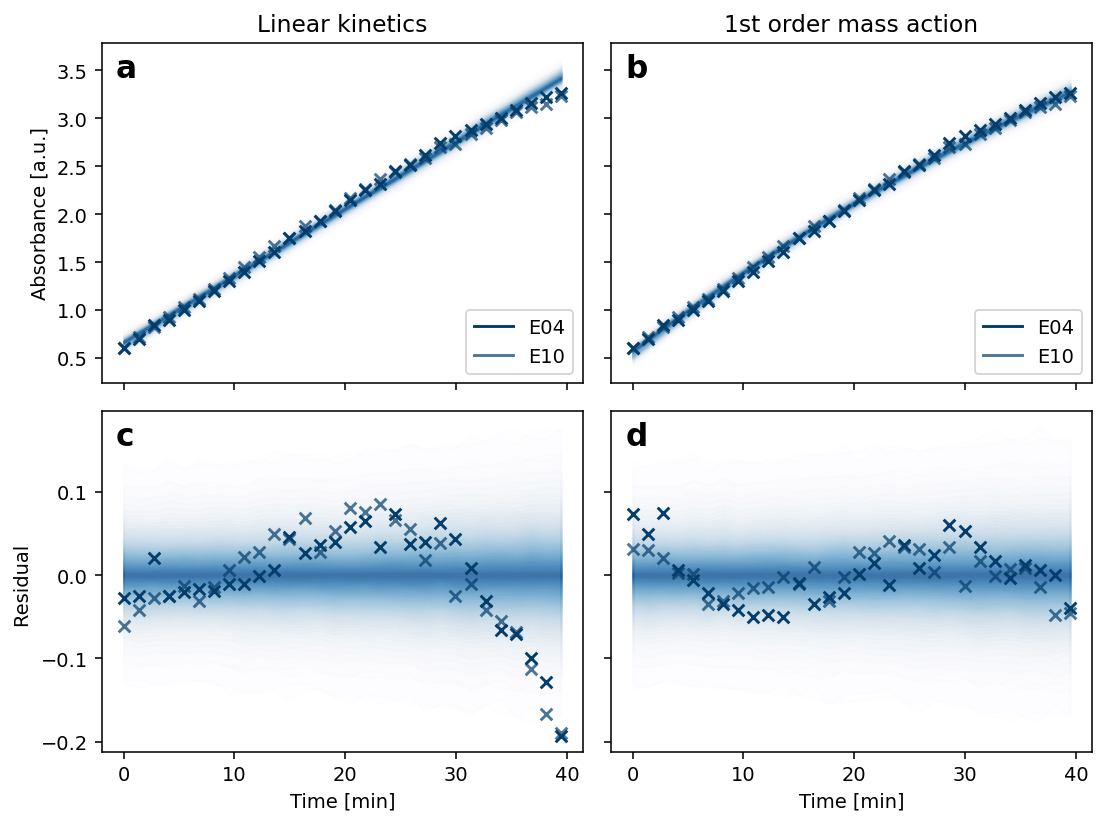

In [5]:
#for strain in posterior.strains.values:
strain="LipB30"
run = "BZACW9"
culture_ids = [idx for idx in df_inputs[df_inputs.strain==strain].index if run in idx]
fig, axs = pyplot.subplots(
        dpi=140,
        figsize=(8, 6),
        ncols=2,
        nrows=2,
        sharey="row",
        sharex="col",
        squeeze=False,
    )
for c, idata in enumerate([idata_linear, idata_nonlinear]):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    cid = culture_ids[0]
    df = df_kinetics[df_kinetics.culture_id==cid]
    kinetic_ids = df.index
    residual_ptp = 0
    for r, kid in enumerate(kinetic_ids):
        color="#023d6b"
        cmap = "Blues"
        if "_1" in kid:
            # and the actual absorbance
            absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
            #print(color, kid, cid)

            axs[0,c].scatter(
                idata.constant_data.cutinase_time.values[0,:],
                absorbance,
                marker="x",
                color=color,
                zorder=10,
                alpha=1-r*0.3
            )
            theta = [
                posterior.absorbance_intercept.sel(kinetic_id=kid).values
            ] + list(cm_nitrophenol.theta_fitted[1:])
            loc, scale, df = cm_nitrophenol.predict_dependent(
                posterior.product_concentration.sel(kinetic_id=kid).values,
                theta=theta

            )
            pp_samples = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

            pymc.gp.util.plot_gp_dist(
                ax=axs[0,c],
                samples=pp_samples.T,
                x=idata.constant_data.cutinase_time.values[0,:],
                palette=cmap,
                plot_samples=False,
                fill_alpha=0.05
            )

            #residuals
            median = numpy.median(pp_samples, axis=1)
            residuals = absorbance.values - median
            residual_ptp = max(residual_ptp, numpy.ptp(residuals))

            pymc.gp.util.plot_gp_dist(
                ax=axs[1, c],
                samples=(pp_samples - median[:,None]).T,
                x=idata.constant_data.cutinase_time.values[0,:],
                plot_samples=False,
                palette=cmap,
                fill_alpha=0.05,
            )
            axs[1, c].scatter(
                idata.constant_data.cutinase_time.values[0,:], residuals, marker="x", color=color, zorder=10,
                alpha=1-r*0.3
            )
            axs[0, c].plot([], [], color=color, alpha=1-r*0.3, label=kid.split("1_")[-1])
    # formatting
    
    axs[1, c].set_xlabel("Time [min]") 
    axs[0, c].legend(loc="lower right")
axs[0, 0].set_title(f"Linear kinetics")
axs[0, 1].set_title(f"1st order mass action")
axs[0, 0].set_ylabel(
    "Absorbance [a.u.]"
)
#axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
axs[1, 0].set_ylabel("Residual ")
for n, ax in enumerate(axs.flatten()):
    ax.text(0.03, 0.9, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

fig.tight_layout()
pyplot.savefig("Linear_vs.non_linear-model.png")